## Imports and Utils

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from Environments.windy_gridworld import WindyGridworld

In [14]:
def compute_q_star(env, gamma=1.0, tol=1e-6):
    """
    Compute optimal Q* for Windy Gridworld via value iteration.
    Returns:
        Q_star : array of shape (R, C, 4)
    """
    R, C = env.R, env.C
    A = 4  # actions

    # initialize V arbitrarily (zero OK)
    V = np.zeros((R, C))
    V_new = np.zeros_like(V)

    while True:
        for r in range(R):
            for c in range(C):

                # terminal state
                if (r, c) == env.goal:
                    V_new[r, c] = 0
                    continue

                # evaluate all actions
                vals = []
                for a in range(A):
                    # simulate transition
                    old_state = env.state
                    env.state = (r, c)
                    (r2, c2), rew, done = env.step(a)
                    env.state = old_state

                    if done:
                        vals.append(rew)  # terminal value = reward
                    else:
                        vals.append(rew + gamma * V[r2, c2])

                V_new[r, c] = max(vals)

        # check convergence
        if np.max(np.abs(V_new - V)) < tol:
            break

        V[:] = V_new[:]

    # Now compute Q*
    Q_star = np.zeros((R, C, A))

    for r in range(R):
        for c in range(C):
            for a in range(A):
                old_state = env.state
                env.state = (r, c)
                (r2, c2), rew, done = env.step(a)
                env.state = old_state

                if done:
                    Q_star[r, c, a] = rew
                else:
                    Q_star[r, c, a] = rew + gamma * V_new[r2, c2]

    return Q_star

In [15]:
def ema(x, beta=0.9):
    y = np.zeros_like(x, dtype=float)
    y[0] = x[0]
    for t in range(1, len(x)):
        y[t] = beta * y[t-1] + (1 - beta) * x[t]
    return y


In [21]:
def rms_error(Q, Q_star):
    return np.sqrt(np.mean((Q - Q_star)**2))


In [22]:
def plot_rms(rms_dict, beta=0.9):
    plt.figure(figsize=(10,6))

    for label, rms_vals in rms_dict.items():
        smoothed = ema(rms_vals, beta)
        plt.plot(smoothed, label=str(label))

    plt.xlabel("Episode")
    plt.ylabel("RMS Error vs Q* (EMA-smoothed)")
    plt.title("Convergence of Q-learning to Optimal Q*")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

## Defining Algorithms

In [23]:
def q_learning(env, Q_star, alpha, eps, episodes=500):
    Q = np.zeros_like(Q_star)
    R = env.R; C = env.C
    A = 4

    rms_hist = []

    for ep in range(episodes):
        state = env.reset()
        done = False

        while not done:
            r, c = state

            if np.random.rand() < eps:
                a = np.random.randint(A)
            else:
                a = np.argmax(Q[r, c])

            (r2, c2), rew, done = env.step(a)

            target = rew if done else rew + np.max(Q[r2, c2])
            Q[r, c, a] += alpha * (target - Q[r, c, a])

            state = (r2, c2)

        rms_hist.append(rms_error(Q, Q_star))

    return np.array(rms_hist), Q


## Initial Q Learning Tests to Get Baseline

In [3]:
env1=WindyGridworld()
env1.reset()
env1.viz()

. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
A . . . . . . G . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
Wind: 0 0 0 1 1 1 2 2 1 0



In [32]:
env = WindyGridworld()
Q_star = compute_q_star(env)

configs = [(0.1, 0.1), (0.5, 0.1), (0.1, 0.5), (0.5, 0.5)]
rms_results = {}

for a, e in configs:
    rms_curve, _ = q_learning(env, Q_star, a, e, episodes=500)
    rms_results[(a, e)] = rms_curve

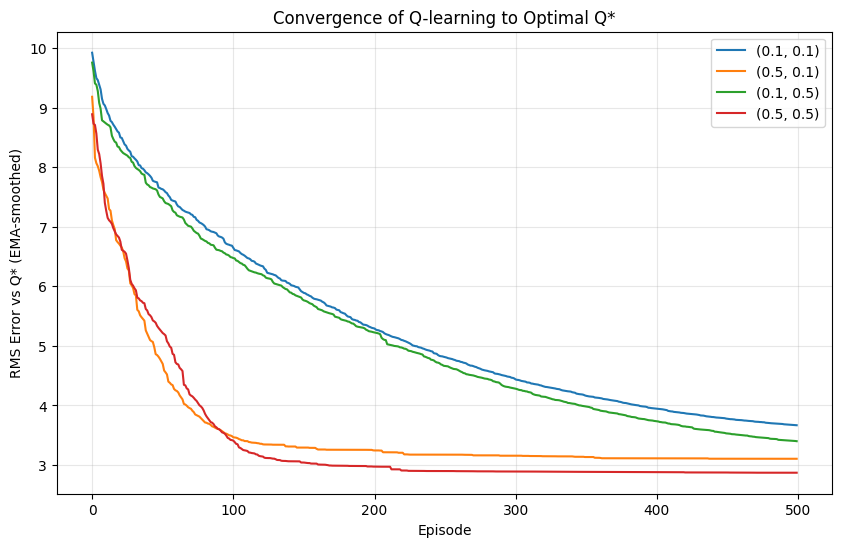

In [33]:
plot_rms(rms_results, beta=0.0)

## RL with COCO 